In [ ]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')  # ignore warnings, like ZeroDivision

# Go up one directory from 'notebooks/' to project root
project_root = os.path.abspath('..')
sys.path.append(project_root)

os.getcwd()

In [2]:
from src.utils_data import *
from src.transformation_utils import *
from src.utils_all import *
from src.GAN.SrGAN_RTM_trainer import *

In [ ]:
from sklearn.model_selection import train_test_split
import pickle

import torch
from torch.utils.data import DataLoader, TensorDataset

In [4]:
print(torch.__version__)
print(torch.cuda.is_available())

# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU is available. Using GPU for computation.")
else:
    # If GPU is not available, fall back to CPU
    device = torch.device("cpu")
    print("GPU is not available. Using CPU for computation.")

2.5.1
True
GPU is available. Using GPU for computation.


In [ ]:
percentage_tr = 1
batch_size = 128
ls_tr = ["cab", "cw", "cm", "LAI", "cp", "cbc", "car", "anth"]

perc = 100
seed_all(seed=4)

checkpoints_path = 'gan_model/checkpoints_Gan_NoRTM_250507_1536_gp0UNlabels_155/'
main_path = os.path.join(project_root, checkpoints_path)

file = open(os.path.join(main_path, 'scaler_all_{}.pkl'.format(perc)), 'rb') 

# # ########## Unlabeled #########
directory_path = os.path.join(project_root, "Splits")
file_paths = glob.glob(os.path.join(directory_path, "*.csv"))
file_paths = file_paths[:int(percentage_tr*len(file_paths))]

################ Data ###############
path_data_lb = os.path.join(project_root, "Datasets/50_all_traits.csv")

# Evaluation

In [31]:
db_lb_all = pd.read_csv(path_data_lb, low_memory=False).drop(['Unnamed: 0'], axis=1)   

### external
groups = db_lb_all.groupby('dataset')

val_ext_idx = list(groups.get_group(32).index)+list(groups.get_group(3).index)
ext_all = db_lb_all.loc[val_ext_idx,:]
db_lb_all.drop(val_ext_idx, inplace=True)

X_labeled, y_labeled = data_prep_db(db_lb_all, ls_tr)
metadata = db_lb_all.iloc[:, :1]  # The metadata (dataset of origin)


red_ed = X_labeled.loc[:,750]
red_end = X_labeled.loc[:,1300]
red1000_ = X_labeled.loc[:,1000]

idx = X_labeled[(red_end>red1000_) & (red_ed>red1000_)].index

if(len(idx)>0):
    # X_labeled.loc[idx,:].T.plot(legend=False)
    X_labeled.drop(idx, inplace=True)
    y_labeled.drop(idx, inplace=True)
    metadata.drop(idx, inplace=True)


# Split labeled data into train (80%), validation (20%)
X_train, X_val= train_test_split(X_labeled, test_size=0.2, stratify=metadata.dataset, random_state=300)

y_train = y_labeled.loc[X_train.index,:]
y_val = y_labeled.loc[X_val.index,:]

meta_train = metadata.loc[X_train.index,:]
meta_val = metadata.loc[X_val.index,:]

ext_val_x = feature_preparation(ext_all.loc[:, '400':'2500']).loc[:, 400:2450]
ext_val_y = ext_all[ls_tr]
###################

# Validation dataset
x_p_val = torch.tensor(X_val.values, dtype=torch.float)
lb_p_val = torch.tensor(y_val.values,dtype=torch.float)

test_dataset = TensorDataset(x_p_val, lb_p_val)
# Create DataLoader for the test dataset
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######## Transferbility ####
x_p_val = torch.tensor(ext_val_x.values, dtype=torch.float)
lb_p_val = torch.tensor(ext_val_y.values,dtype=torch.float)

external_dataset = TensorDataset(x_p_val, lb_p_val)
ext_loader = DataLoader(external_dataset, batch_size=128)

In [32]:
def load_model(main_path, input_shape, type_s, perc=100):
    
    # open a file, where you stored the pickled data
    file = open(os.path.join(main_path, 'scaler_all_{}.pkl'.format(perc)), 'rb') 
    path_model = os.path.join(main_path, 'best_model.h5')

    # dump information to that file
    scaler_list = pickle.load(file)

    settings_dict = {
        'checkpoint_dir': None,
        'train_loader': None,
        'valid_loader': valid_loader,
        'unlabeled_loader': None, 
        
        'scaler_model': scaler_list,
        'n_lb': 8, #y_train.shape[1],
        'input_shape': input_shape,
        'type':type_s,
        'latent_dim': 100,
        'learning_rate': None,
        'weight_decay': None,
        
        'n_epochs': None,
        'batch_size': None,
        
        'rtm_D': True,
        'rtm_G': True,
        
        'lambda_fk': 1.0,
        'lambda_un': 10.0,
        
        'labeled_loss_multiplier': 1.0,
        'matching_loss_multiplier': 1.0,
        'contrasting_loss_multiplier': 1.0,
        
        'gradient_penalty_on': True,
        'gradient_penalty_multiplier': 10.0,
        'srgan_loss_multiplier': 1.0,
        
        'early_stop': True,
        'early_stopping': None,
        'patience': None,
        'logger': None,
        'log_epoch': None,
        
        'mean_offset': None,
        'normalize_fake_loss': False,
        'normalize_feature_norm': False,
        
        'contrasting_distance_function': nn.CosineEmbeddingLoss(),
        'matching_distance_function': nn.CosineEmbeddingLoss(),
        'labeled_loss_function': HuberCustomLoss(threshold=1.0),

        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    sets = Settings()
    sets.update_from_dict(settings_dict)

    test_reg = SrGAN_RTM(sets)
    test_reg.dataset_setup()
    test_reg.model_setup()
    test_reg.transformation_setup()
    
    test_reg.model = torch.load(path_model) #, map_location=torch.device('cpu')
    return test_reg



def eval(main_path, valid_loader, input_shape, type_s, perc=100):
    test_reg = load_model(main_path, input_shape, type_s, perc=perc)

    preds = torch.empty(0,8).to(device)
    ori = torch.empty(0,8).to(device)

    test_reg.eval_mode()

    with torch.no_grad():
        for data_val, lb_bx_val in valid_loader:
            lb_bx_val = lb_bx_val.float().to(device)
            data_val = data_val.unsqueeze(dim=1)[:,:,:-1].float().to(device)

            pred = test_reg.model(data_val)[0]

            if(test_reg.settings.scaler_model is not None):
                preds_D = test_reg.transformation_layer_inv(pred) ### shoud keep the sam eorder of labels !!!
                
            elif(test_reg.settings.scaler_list is not None):
                preds_D = torch.tensor(test_reg.settings.scaler_list.inverse_transform(pred.cpu().detach().numpy()), dtype=torch.float32)#.requires_grad_(True)
            else:
                preds_D = pred.clone

            ori = torch.cat((ori.data, lb_bx_val.data), dim=0)
            preds = torch.cat((preds.data, preds_D.data), dim=0)

    ori_lb = pd.DataFrame(ori.cpu(), columns=ls_tr[:])
    df_tr_val = pd.DataFrame(preds.cpu(), columns=ls_tr[:])

    return ori_lb, df_tr_val

In [33]:
ori_lb, df_tr_val = eval(main_path, ext_loader, 1720, 'full', perc=100)
eval_metrics(ori_lb, df_tr_val)

,r2_score,RMSE,nRMSE (%),MAE,Bias,RPD,spearmanr_squared
cab,0.542333,8.757144,14.412763,7.099945,1.965376,1.480203,0.570360
cw,0.198442,0.009198,19.819808,0.006326,0.004973,1.118735,0.272920
cm,0.766282,0.003473,11.308811,0.002195,0.001204,2.071804,0.492385
LAI,0.265474,1.258467,21.270981,1.014896,-0.377375,1.168860,0.316185
cp,0.284368,0.000271,20.052087,0.000205,0.000060,1.188651,0.366971
cbc,0.336629,0.005506,21.462527,0.004114,0.003119,1.234586,0.565598
car,0.030375,2.227647,19.470538,1.649815,0.948071,1.016940,0.228946
anth,0.292959,0.330726,19.325010,0.257457,0.026584,1.191377,0.373399


Text(0.02, 0.5, 'Observations')

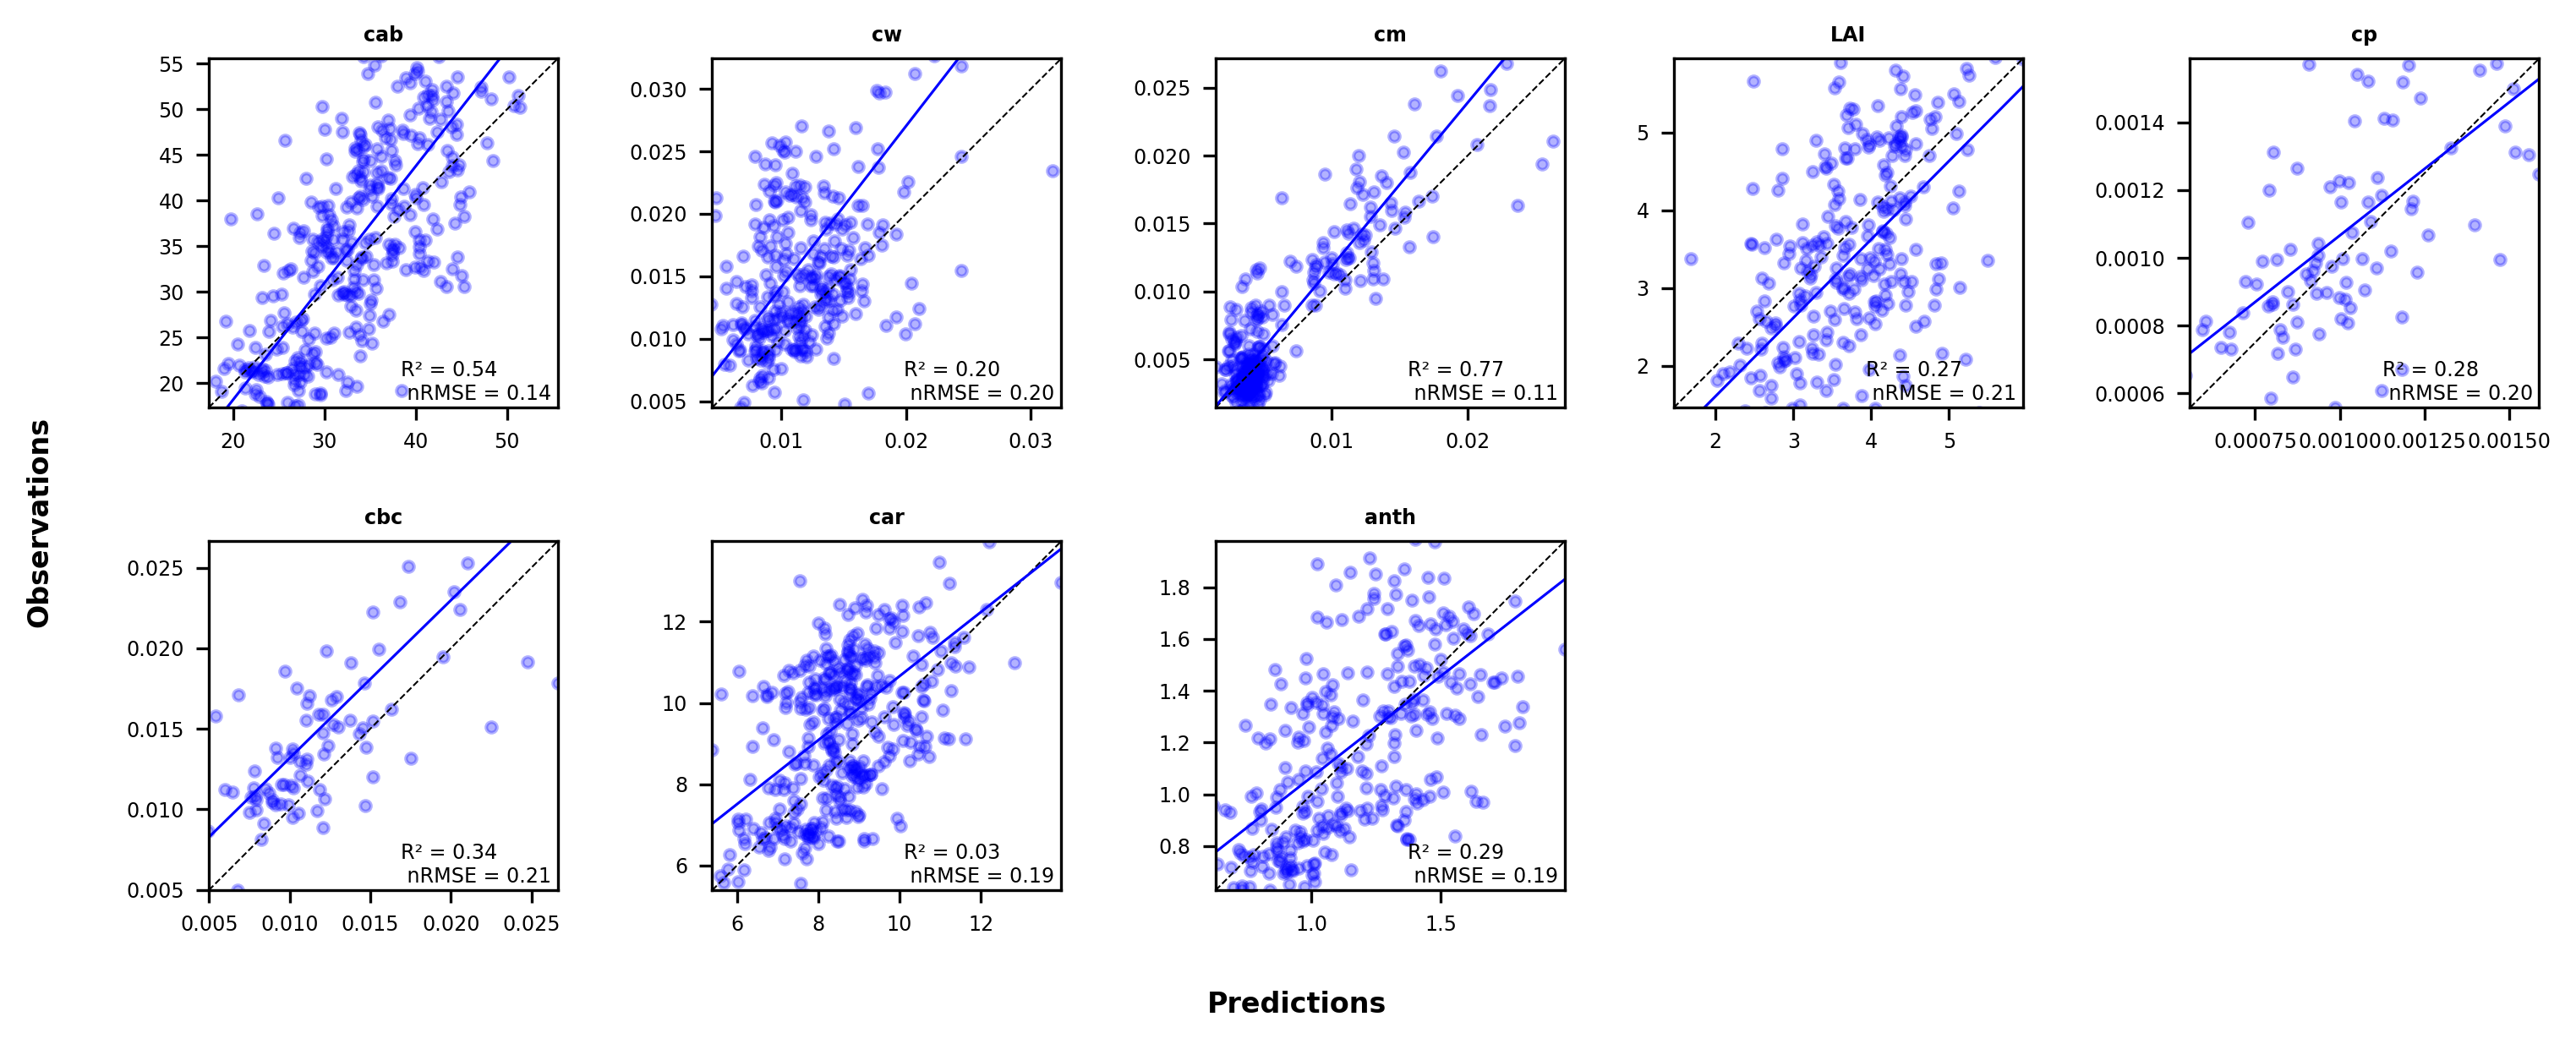

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

import seaborn as sns

size = 5.7
quantile_vis = 1
# test_tr = Traits[:-1]
figsize = (10,4)

plt.rc('font', size=size) #5.7
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.5

a = 2 # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = figsize,dpi=300 ,constrained_layout=True)
Traits = test_tr = list(ori_lb.columns)

for tr in range(len(test_tr)):
        
    pred = df_tr_val.iloc[:,tr]
    true = ori_lb.iloc[:,tr]
    
    norm = (np.nanquantile(true, 0.99) - np.nanquantile(true, 0.01))
    
    f = pred.copy().reset_index(drop=True)
    y = true.copy().reset_index(drop=True)
    
    idx = np.union1d(f[f.isna()].index,y[y.isna()].index)
    
    f.drop(idx, axis = 0, inplace=True)
    y.drop(idx, axis = 0, inplace=True)
    
    r2 = r2_score(y,f)
    nrmse = math.sqrt(mean_squared_error(y,f))/norm
    nmae = mean_absolute_error(y,f)/norm

    ax1 = plt.subplot(a, b, c)
    plt.axis('square')
    
    lim_max = min(f.quantile(quantile_vis),y.quantile(quantile_vis)) 
    lim_min = max(f.quantile(1-quantile_vis),y.quantile(1-quantile_vis))
    
    #######
    ax1.set_xlim(lim_min,lim_max)
    ax1.set_ylim(ax1.get_xlim())
    ax1.set_aspect('equal', adjustable='box')

    sns.lineplot(x=(lim_min,lim_max), y=(lim_min,lim_max), ax = ax1, color='black',legend='full', linestyle='dashed')

    sns.regplot(x= pred, color='b', y=true,fit_reg= True,ax=ax1, ci=False, scatter_kws={"color": "blue", 'alpha':0.3})
    # sns.regplot(x= f, y=y, color='b', fit_reg= True, ax=ax1, scatter=False)

    ann = 'R² = {0:.2f} \n nRMSE = {1:.2f}'.format(r2, nrmse)
    
    ax1.annotate(ann,
    xy=(0.55,0.01),
    xycoords='axes fraction',
    horizontalalignment='left',
    verticalalignment='bottom',size=size)

    ann = test_tr[tr]
    ax1.set_title(ann, y=1.1, pad=-5, fontdict = {'fontsize':size,
    'horizontalalignment': 'center', 'fontweight':'bold'})
    
    plt.xlabel(" ")
    plt.ylabel(" ")
    
    c+=1

fig.supxlabel('Predictions', size=8, fontweight='bold', ha='center')
fig.supylabel('Observations', size=8, fontweight='bold', ha='center')

<Axes: >

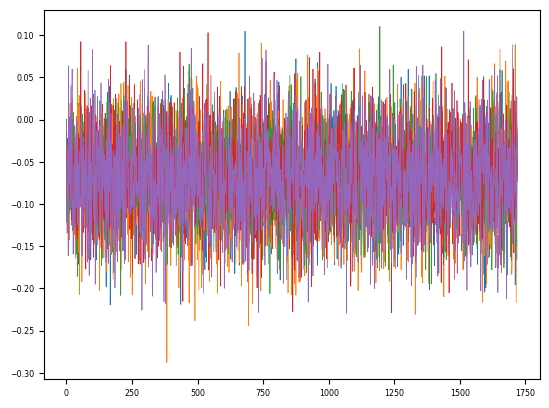

In [35]:
##### Visualize the generator signal 
#import matplotlib.pyplot as plt
test_reg = load_model(main_path, 1720, 'full', perc=100)

# Generate spectra
z_train = torch.randn(5, test_reg.settings.latent_dim)#.to(device)

gen_spectra = test_reg.G(z_train)

pd.DataFrame(gen_spectra.squeeze(dim=1).cpu().detach().numpy()).T.plot(legend=False)